## Business understanding
This notebook analyzed Seattle Airbnb open data. The data consists of listings, reviews, and price by date. To understand where to live and when to visit Seattle and the Airbnb market, this analysis will explore three questions.

- Can you describe the vibe of each Seattle neighborhood using listing descriptions?
- What are the busiest times of the year to visit Seattle? By how much do price spike?
- Is there a general upward trend of both new Airbnb listings and total visitors to Seattle?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import nltk
nltk.download(['punkt','wordnet','stopwords'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from datetime import date
import re
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

[nltk_data] Downloading package punkt to /Users/kaiqi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kaiqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kaiqi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
listings_df = pd.read_csv('listings.csv')
reviews_df = pd.read_csv('reviews.csv')
calendar_df = pd.read_csv('calendar.csv')

# A look at the data

In [3]:
listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [4]:
listings_df.shape

(3818, 92)

In [5]:
# columns without missing values
listings_df.columns[listings_df.isnull().mean()==0]

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'experiences_offered', 'picture_url', 'host_id', 'host_url',
       'host_verifications', 'street', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'room_type', 'accommodates', 'bed_type',
       'amenities', 'price', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'calendar_updated',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'calendar_last_scraped',
       'number_of_reviews', 'requires_license', 'jurisdiction_names',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count'],
      dtype='object')

In [6]:
# columns with missing values over 75%
most_missing_columns = listings_df.columns[listings_df.isnull().mean() >0.75]
most_missing_columns

Index(['square_feet', 'license'], dtype='object')

## Q1. Describe the vibe of each Seattle neighborhood using listing descriptions

Apply Tfidf to extract the key words of neighborhood.

In [7]:
neighborhood_df = listings_df[['neighbourhood_cleansed','neighborhood_overview']]


In [8]:
neighborhood_listing = neighborhood_df.groupby('neighbourhood_cleansed').count().sort_values(by = 'neighborhood_overview', ascending = False).head().reset_index()
neighborhood_listing.columns = ['neighborhood_cleansed','listings']

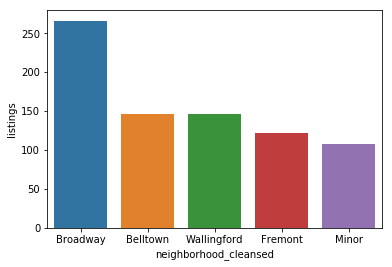

In [9]:
listing_bar = sns.barplot(x = 'neighborhood_cleansed', y = 'listings', data = neighborhood_listing)

In [10]:
listing_fig = listing_bar.get_figure()
listing_fig.savefig("listing_bar.png")

In [11]:
# remove nans in the dataframe
neighborhood_nona = neighborhood_df.dropna()

In [12]:
neighborhood_combined = neighborhood_nona.groupby('neighbourhood_cleansed')['neighborhood_overview'].apply(' '.join).reset_index()

In [13]:
def tokenize(text):
    """
    This function nomalizes case and remove punctuation and tokenize and lemmatize text.
    input: text
    output: tokens
    """
    # nomalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]"," ",text.lower())

    # tokenize text
    tokens = word_tokenize(text)

    # lemmatize and remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word).strip() for word in tokens if word not in stop_words]
    
    return tokens

In [14]:
documents = []
for idx in neighborhood_combined.index:
    document = str(neighborhood_combined.iloc[idx]['neighborhood_overview'])
    documents.append(document)

#documents[0]

In [15]:
# get the term frequency
vec = CountVectorizer(tokenizer = tokenize)
# generates word counts for the words in docs
word_count_vector = vec.fit_transform(documents)

In [17]:
tfidf = TfidfTransformer(smooth_idf = True,use_idf = True)
tfidf_vector = tfidf.fit_transform(word_count_vector)

In [18]:
def get_key_words(neighborhood):
    feature_names = vec.get_feature_names()
    idx = neighborhood_combined.index[neighborhood_combined['neighbourhood_cleansed'] == neighborhood]
    
    tfidf_document_vector = tfidf_vector[idx]
    df = pd.DataFrame( tfidf_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
    return df.sort_values(by=["tfidf"],ascending=False)

In [19]:
get_key_words('Broadway').head(20)

,tfidf
capitol,0.368788
hill,0.308805
seattle,0.216016
broadway,0.200126
restaurant,0.178996
bar,0.172969
neighborhood,0.170418
walk,0.164420
volunteer,0.158619
pine,0.155027


In [20]:
get_key_words('Belltown').head(20)

,tfidf
0,0.422270
seattle,0.318828
belltown,0.271944
mile,0.215498
center,0.183724
pike,0.177205
place,0.170535
needle,0.146685
science,0.142292
block,0.135102


In [21]:
get_key_words('Fremont').head(20)

,tfidf
fremont,0.555069
troll,0.176178
universe,0.169516
neighborhood,0.160762
restaurant,0.135500
burke,0.133507
seattle,0.132205
factory,0.128708
park,0.126608
chocolate,0.122903


# Q2. What are the busiest times of the year to visit Seattle? By how much do price spike?

In [22]:
data_2 = calendar_df[calendar_df['available']=='t']
data_2.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
9,241032,2016-01-13,t,$85.00
10,241032,2016-01-14,t,$85.00
14,241032,2016-01-18,t,$85.00


In [23]:
# look at the available listings
listing_date = data_2.groupby('date').count()['listing_id'].reset_index()

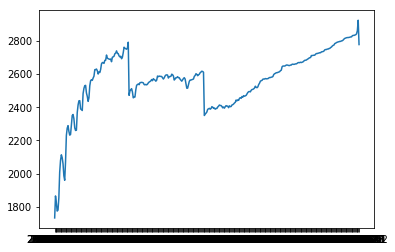

In [24]:
plt.plot(listing_date['date'],listing_date['listing_id'])
plt.show()

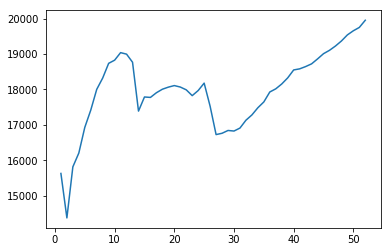

In [25]:
# Let's look at the listings by week.
data_2['date'] = pd.to_datetime(data_2['date'])
data_2['week'] = data_2['date'].dt.week
listing_week = data_2.groupby('week').count()['listing_id'].reset_index()
plt.plot(listing_week['week'],listing_week['listing_id']) 


In [26]:
data_2['price'] = data_2['price'].str.replace(',','')
data_2['price'] = data_2['price'].str.replace('$','').astype(float)

In [27]:
price_date = data_2.groupby('date').mean()['price'].reset_index()

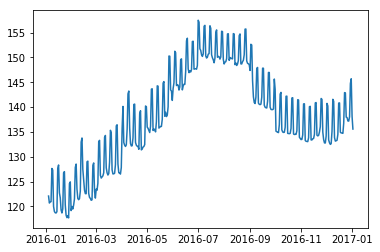

In [28]:
# look at price by day
plt.plot(price_date['date'],price_date['price'])
plt.savefig('price.png')

Notice the seasonal variations

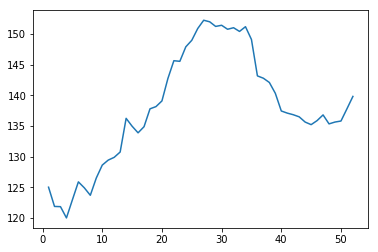

In [29]:
# look at the average price by week
price_week = data_2.groupby('week').mean()['price'].reset_index()
plt.plot(price_week['week'],price_week['price'])

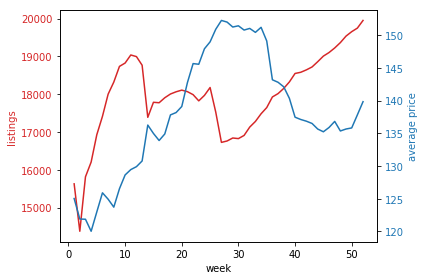

In [30]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('week')
ax1.set_ylabel('listings', color = color)
ax1.plot(listing_week['week'],listing_week['listing_id'],color = color)
ax1.tick_params(axis ='y',labelcolor = color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('average price',color = color)
ax2.plot(price_week['week'],price_week['price'],color = color)
ax2.tick_params(axis = 'y',labelcolor = color)

fig.tight_layout()
plt.savefig('list_price.png')
plt.show()


when putting the listings and average price by week in one plot, we can see the available listings is also low when price gets higher.

# Q3. Is there a general upward trend of both new Airbnb listings and total visitors to Seattle?

In [31]:
listings_df['host_since'] = pd.to_datetime(listings_df['host_since'])
listings_df['year'] = listings_df['host_since'].dt.year

In [32]:
new_hosts = listings_df.groupby('year').count()['id'].reset_index()

In [33]:
new_hosts['year'] = new_hosts['year'].astype(int)

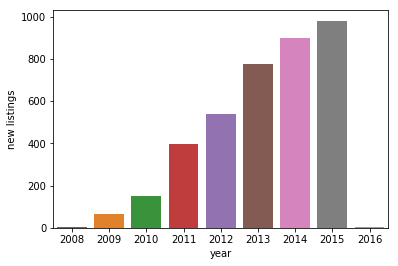

In [34]:
# look at the new listing in each year
ax = sns.barplot(data = new_hosts,x = 'year',y = 'id')
ax.set_ylabel('new listings')
newlist_fig = ax.get_figure()
newlist_fig.savefig("new_listing.png")

In [35]:
reviews_df['date'] = pd.to_datetime(reviews_df['date'])
reviews_df['year'] = reviews_df['date'].dt.year

In [36]:
reviews_year = reviews_df.groupby('year').count()['id'].reset_index()

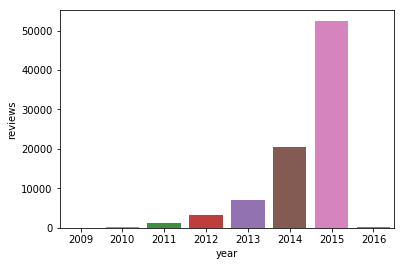

In [37]:
# number of reivews in each year
ax = sns.barplot(data = reviews_year,x = 'year',y = 'id')
ax.set_ylabel('reviews')
review_fig = ax.get_figure()
review_fig.savefig("review_bar.png")